In [147]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Check cuda version in cmd
# nvcc --version
# Check GPU driver version
# nvidia-smi

In [148]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [149]:
# Check PyTorch version
print("PyTorch version:", torch.__version__)
# Show Cuda GPU device
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_arch_list())
print(torch.backends.cudnn.version())

PyTorch version: 2.0.1
NVIDIA GeForce GTX 1050 Ti
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'compute_37']
8700


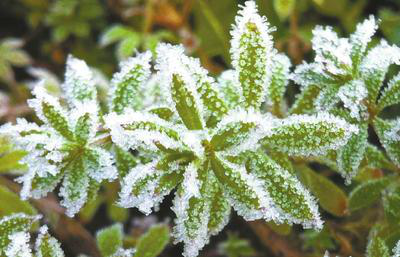

In [150]:
# Open one image from the dataset
path = 'dataset'
with Image.open(path + '/frost/3600.jpg') as img:
    display(img)

In [151]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(path, transform=None)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset

In [152]:
# Display number of classes in the dataset
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


## Convert dataset into CSV file

In [153]:
# List to store image paths and corresponding labels
data = []

# Loop through each label directory
for label_name in os.listdir(path):
    label_dir = os.path.join(path, label_name)
    if os.path.isdir(label_dir):
        # Loop through each image file in the label directory
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                label = label_name
                data.append((image_path, label))

# Convert the data list into a Pandas DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])

# Save the DataFrame to a CSV file
csv_file = 'dataset.csv'  # Change the filename if desired
df.to_csv(csv_file, index=False)

In [154]:
# Load csv file and show first 5 rows
df = pd.read_csv('dataset.csv')
df.head() 

,image_path,label
0,dataset\dew\2208.jpg,dew
1,dataset\dew\2209.jpg,dew
2,dataset\dew\2210.jpg,dew
3,dataset\dew\2211.jpg,dew
4,dataset\dew\2212.jpg,dew


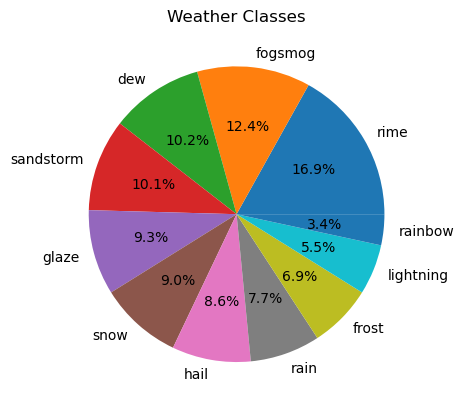

In [155]:
# Plot a pie chart to visualize % of each class in the dataset
label_counts = df["label"].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Weather Classes')
plt.show()

## Split dataset into train, validation and test sets

In [156]:
# Set the random seed
torch.manual_seed(16)

# Split dataset into train and test
train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
validation_size = len(train_data_old) - train_size
train_data, validation_data = torch.utils.data.random_split(train_data_old, [train_size, validation_size])

## Define transforms for each set

In [157]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Apply transformation mechanism for each set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5,contrast=0.3,saturation=0.5,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
validation_data.dataset.transform = val_transform

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

## Create data loaders for each set of data

In [158]:
# Set the random seed
torch.manual_seed(16)

# Batch size
batch = 32

# Define Data Loaders
train_loader = DataLoader(train_data, batch_size=batch, pin_memory=True, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch, pin_memory=True, shuffle=False)

# Define variables for sizes of each set
train_data_len = len(train_data)
val_data_len = len(validation_data)
test_data_len = len(test_data)

print("Training images available:", train_data_len)
print("\t")
print("Validation images available:", val_data_len)
print("\t")
print("Testing images available:", test_data_len)

Training images available: 4957
	
Validation images available: 875
	
Testing images available: 1030


In [161]:
# Display one tensor from train data
train_data[0]

(tensor([[[-1.6384, -1.6384, -1.6384,  ..., -1.4500, -1.4500, -1.4500],
          [-1.6213, -1.6213, -1.6384,  ..., -1.4672, -1.4672, -1.4500],
          [-1.6213, -1.6213, -1.6384,  ..., -1.4672, -1.5014, -1.4500],
          ...,
          [-1.5014, -1.5870, -1.2959,  ..., -0.9534, -1.0219, -1.0219],
          [-1.5528, -1.6384, -1.7069,  ..., -1.0219, -1.0219, -1.0390],
          [-1.5870, -1.6898, -1.7754,  ..., -1.0390, -1.0390, -1.0733]],
 
         [[-1.2829, -1.3004, -1.3004,  ..., -0.9853, -1.0203, -0.9853],
          [-1.2654, -1.2829, -1.3004,  ..., -1.0028, -1.0203, -0.9853],
          [-1.2654, -1.2829, -1.3004,  ..., -1.0203, -1.0203, -0.9853],
          ...,
          [-1.1429, -1.2479, -0.9853,  ..., -0.4426, -0.4426, -0.4601],
          [-1.2129, -1.3179, -1.4230,  ..., -0.4776, -0.4251, -0.4601],
          [-1.2829, -1.3880, -1.4580,  ..., -0.4776, -0.4251, -0.4601]],
 
         [[-1.6302, -1.6476, -1.6476,  ..., -1.7347, -1.7173, -1.7173],
          [-1.6127, -1.6302,

Class Indexes: [8 4 8 8 7 1 8 1 2 8 1 1 4 7 7 3]
	
Sample image size: torch.Size([3, 224, 224])
	


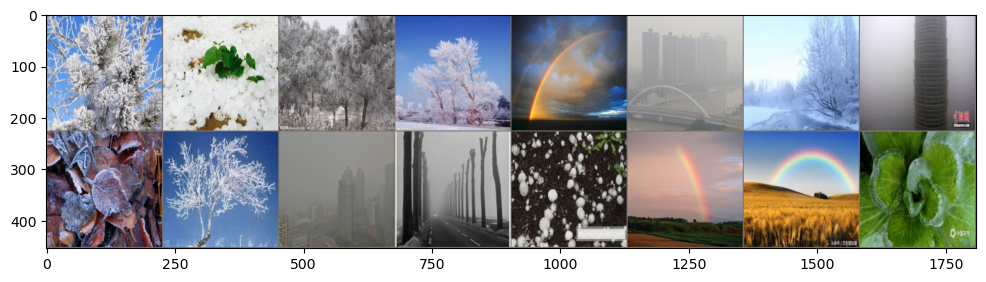

In [165]:
# Grab the first batch of images
for images, labels in train_loader: 
    break
    
# Extract the first 16 images
images_subset = images[:16]
labels_subset = labels[:16]

# Print the labels
print('Class Indexes:', labels_subset.numpy())
print("\t")

# Make a grid with 8 images in each row
im = make_grid(images_subset, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images_subset[0].shape)
print("\t")

# Define functions

## Count number of trainable parameters

In [170]:
def count_parameters(model):
    print("Total sum of weights in the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

## Hyperparameter tuning

In [171]:
def hyperparameter_tuning(model, optimizer_model, learning_rates, batch_sizes, model_name):

    start_time = time.time()
    model_name = model_name

    best_lr = None
    best_batch_size = None
    best_accuracy = 0.0
    epochs = 50

    
    for lr in learning_rates:
        for batch in batch_sizes:

            train_loader = DataLoader(train_data, batch_size=batch, pin_memory=True, shuffle=True)
            validation_loader = DataLoader(validation_data, batch_size=batch, pin_memory=True, shuffle=False)
            
            model.to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.AdamW(optimizer_model, lr=lr)
            
            # Move optimizer state to the GPU
            for state in optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(device)

            print("\t")
            print(f"training {model_name} with learning rate:", lr, "and batch size:", batch)
            print("_________________________________________________________________________")
            print("\t")

            # Define patience, counter, best validation accuracy and
            # a boolean value that determines if early stop mechanism is to be activated
            patience = 4
            counter = 0
            best_val_acc = 0
            is_early_stop = False

            # For each epoch run the training and validation bathes
            for epoch in range(epochs):
                train_corr = 0
                validation_corr = 0

                # Run the training batches
                for images, labels in train_loader:
                    
                    images = images.to(device)
                    labels = labels.to(device)

                    # Apply the model for training
                    outputs = model(images)
                    # Number of losses
                    loss = criterion(outputs, labels)

                    # Number of correct predictions
                    predicted = torch.max(outputs.data, 1)[1]
                    train_corr += (predicted == labels).sum()

                    # Update parameters during training
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Calculate accuracy after each epoch
                accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

                # Print each epoch results
                print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3), 
                      "Train accuracy:", accuracy_train, "%")




                # Run the validation batches
                model.eval()

                with torch.no_grad():
                    for images, labels in validation_loader:
                        
                        images = images.to(device)
                        labels = labels.to(device)

                        # Apply the model for validation
                        outputs = model(images)
                        # Number of losses
                        loss = criterion(outputs, labels)

                        # Number of correct predictions
                        predicted = torch.max(outputs.data, 1)[1] 
                        validation_corr += (predicted == labels).sum()

                    # Calculate accuracy after each epoch
                    accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)    



                    # Early stopping
                    if accuracy_val > best_val_acc:
                        best_val_acc = accuracy_val
                        counter = 0
                    else:
                        counter += 1

                    # Check for early stopping after the validation loop    
                    if counter >= patience:
                        is_early_stop = True
                        print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                              "Validation accuracy:", accuracy_val, "%")            
                        print("Early stopping triggered. Training stopped.")
                        break


                if is_early_stop:
                    break
                else:
                    # Print each epoch results
                    print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3), 
                          "Validation accuracy:", accuracy_val, "%")
                    print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
                    print("\t")


            # Check if the current hyperparameters achieved better accuracy
            if best_val_acc > best_accuracy:
                best_accuracy = best_val_acc
                best_lr = lr
                best_batch_size = batch
                print("Current best Hyperparameters: Learning Rate:", best_lr, "Batch Size:", best_batch_size, 
                      "Accuracy:", best_accuracy)


    print("\n")
    print("Best Hyperparameters overall: Learning Rate:", best_lr, "Batch Size:", best_batch_size, "Accuracy:", best_accuracy)
    print("\t")
    print("Duration:", round(time.time() - start_time, 1), "seconds")

## Train and validate model

In [172]:
def train_and_val_model(model, criterion, optimizer, train_loader, val_loader, model_name,
                        train_loss_list, train_corr_list, val_loss_list, val_corr_list):
    start_time = time.time()
    # Number of epochs
    epochs = 50
    
    model_name = model_name

    # Define patience, counter, best validation accuracy and
    # a boolean value that determines if early stop mechanism is to be activated
    patience = 4
    counter = 0
    best_val_acc = 0
    is_early_stop = False


    # For each epoch run the training and validation bathes
    for epoch in range(epochs):
        train_corr = 0
        validation_corr = 0

        # Run the training batches
        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for training
            outputs = model(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            train_corr += (predicted == labels).sum()

            # Update parameters during training
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Append losses and correct predictions per epoch
        train_loss_list.append(loss)
        train_corr_list.append(train_corr)

        # Calculate accuracy after each epoch
        accuracy_train = round(train_corr.item() * 100 / train_data_len, 3)

        # Print each epoch results
        print("Epoch:", epoch + 1, "Train loss:", round(loss.item(), 3),
              "Train accuracy:", accuracy_train, "%")




        # Run the validation batches
        model.eval()

        with torch.no_grad():
            for images, labels in val_loader:

                images = images.to(device)
                labels = labels.to(device)

                # Apply the model for validation
                outputs = model(images)
                # Number of losses
                loss = criterion(outputs, labels)

                # number of correct predictions
                predicted = torch.max(outputs.data, 1)[1]
                validation_corr += (predicted == labels).sum()

            # Calculate accuracy after each epoch
            accuracy_val = round(validation_corr.item() * 100 / val_data_len, 3)



            # Early stopping
            if accuracy_val > best_val_acc:
                best_val_acc = accuracy_val
                counter = 0

                # Save model with best accuracy
                torch.save(model.state_dict(), f"Best{model_name}.pt")
            else:
                counter += 1

            # Check for early stopping after the validation loop
            if counter >= patience:
                is_early_stop = True
                print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                      "Validation accuracy:", accuracy_val, "%")
                print("Early stopping triggered. Training stopped.")
                break


        # Append losses and correct predictions per epoch
        val_loss_list.append(loss)
        val_corr_list.append(validation_corr)

        if is_early_stop:
            break
        else:
            # Print each epoch results
            print("Epoch:", epoch + 1, "Validation loss:", round(loss.item(), 3),
                  "Validation accuracy:", accuracy_val, "%")
            print("best_val_acc:", round(best_val_acc, 3), "counter:", counter)
            print("\t")


    print("\n")
    print("Duration:", round(time.time() - start_time, 1), "seconds")

## Test model

In [173]:
accuracy_global = 0.0

def test_model(model_best, criterion, test_loader, test_corr_list):

    global accuracy_global
    test_corr = 0

    # Run the test batches
    model_best.eval()

    with torch.no_grad():
        for images, labels in test_loader:

            images = images.to(device)
            labels = labels.to(device)

            # Apply the model for validation
            outputs = model_best(images)
            # Number of losses
            loss = criterion(outputs, labels)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            test_corr += (predicted == labels).sum()

        # Calculate accuracy
        accuracy = round(test_corr.item() * 100 / test_data_len, 3)

    test_corr_list.append(test_corr)
    accuracy_global = accuracy

## Confusion Matrix

In [174]:
def show_confusion_matrix(model_best):
    
    # Create a loader for the entire test set
    test_load_all = DataLoader(test_data, batch_size=test_data_len, shuffle=False)
    model_best.cpu()

    with torch.no_grad():
        correct = 0
        for images, labels in test_load_all:

            images = images.cpu()
            labels = labels.cpu()

            outputs = model_best(images)
            predicted = torch.max(outputs, 1)[1]
            correct += (predicted == labels).sum()

    arr = confusion_matrix(labels.view(-1), predicted.view(-1))
    df_cm = pd.DataFrame(arr, classes, classes)
    plt.figure(figsize = (9,6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show();

## Model prediction on single image

In [175]:
def custom_img_prediction(model_best, model_name):
    model_name = model_name
    
    model_best.cpu()
    model_best.eval()
    with torch.no_grad():
        custom_pred = model_best(custom_img_t.view(1,3,224,224)).argmax()

    print(f"{model_name} model prediction:", custom_pred.item())

# Custom CNN

## Define the Convolutional Network (custom CNN)

In [93]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        
        # Convolutional layer
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Batch Normalization layer
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        # Activation layer
        self.relu = nn.ReLU()
        # Pooling Layer
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(32 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 11)
        # Dropout layer
        self.dropout1 = nn.Dropout2d(p=0.3)
        self.dropout2 = nn.Dropout2d(p=0.2)

    def forward(self, x):
        # 1st Convolutional layer
        x = self.max_pool(self.relu(self.bn1(self.conv1(x))))
        # 2nd Convolutional layer
        x = self.max_pool(self.relu(self.bn2(self.conv2(x))))
        # 3rd Convolutional layer
        x = self.max_pool(self.relu(self.bn3(self.conv3(x))))
        # Flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # 1st Fully Connected layer
        x = self.dropout1(self.relu(self.fc1(x)))
        # 2nd Fully Connected layer
        x = self.dropout2(self.relu(self.fc2(x)))
        # 3rd Fully Connected layer
        x = self.fc3(x)
        # Output layer
        return F.log_softmax(x, dim=1)
    

# (224/2/2/2) = we divided 224 by the number of conv layers by calling pooling layers,
# which leaves us at 28 pixels per side

In [94]:
# Instantiate the model, define loss and optimization functions
CNNmodel = ConvolutionalNetwork()
print(CNNmodel)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=11, bias=True)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.2, inplace=False)
)


In [95]:
# Move model to Cuda GPU
CNNmodel.to(device)
next(CNNmodel.parameters()).is_cuda

True

In [96]:
count_parameters(CNNmodel)

Total sum of weights in the model:
	
     162
       6
     864
      16
    4608
      32
       6
       6
      16
      16
      32
      32
 6422528
     256
   32768
     128
    1408
      11
________
 6462895


In [97]:
# Define loss and optimization functions
criterion_CNNmodel = nn.CrossEntropyLoss()
optimizer_CNNmodel = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)

In [98]:
# Move optimizer state to the GPU
for state in optimizer_CNNmodel.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

## Train the model (custom CNN)

In [100]:
# Create lists to append losses and correct predictions per epoch
train_loss_CNNmodel = []
train_corr_CNNmodel = []
val_loss_CNNmodel = []
val_corr_CNNmodel = []

train_and_val_model(CNNmodel, criterion_CNNmodel, optimizer_CNNmodel, train_loader, validation_loader, "CNNmodel",
                        train_loss_CNNmodel, train_corr_CNNmodel, val_loss_CNNmodel, val_corr_CNNmodel)

Epoch: 1 Train loss: 0.946 Train accuracy: 45.552 %
Epoch: 1 Validation loss: 0.955 Validation accuracy: 59.657 %
best_val_acc: 59.657 counter: 0
	
Epoch: 2 Train loss: 0.873 Train accuracy: 64.394 %
Epoch: 2 Validation loss: 0.997 Validation accuracy: 66.629 %
best_val_acc: 66.629 counter: 0
	
Epoch: 3 Train loss: 0.903 Train accuracy: 69.861 %
Epoch: 3 Validation loss: 0.91 Validation accuracy: 72.0 %
best_val_acc: 72.0 counter: 0
	
Epoch: 4 Train loss: 0.8 Train accuracy: 76.377 %
Epoch: 4 Validation loss: 0.745 Validation accuracy: 70.743 %
best_val_acc: 72.0 counter: 1
	
Epoch: 5 Train loss: 0.473 Train accuracy: 81.824 %
Epoch: 5 Validation loss: 0.901 Validation accuracy: 71.886 %
best_val_acc: 72.0 counter: 2
	
Epoch: 6 Train loss: 0.322 Train accuracy: 89.147 %
Epoch: 6 Validation loss: 0.81 Validation accuracy: 72.914 %
best_val_acc: 72.914 counter: 0
	
Epoch: 7 Train loss: 0.079 Train accuracy: 93.666 %
Epoch: 7 Validation loss: 0.907 Validation accuracy: 70.514 %
best_val_a

## Evaluate model performance (custom CNN)

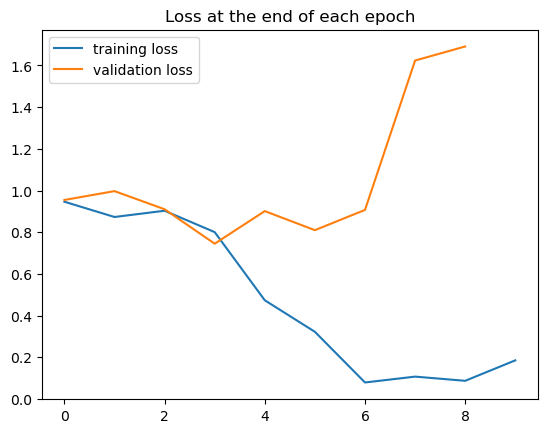

In [103]:
# Plot Losses
plt.plot([t.cpu().detach().numpy() for t in train_loss_CNNmodel], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_CNNmodel], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

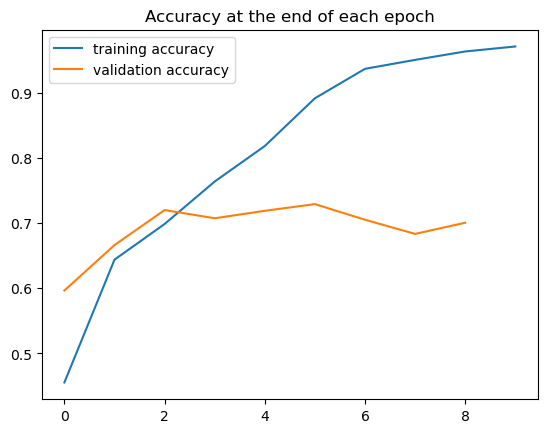

In [102]:
# Plot accuracy
plt.plot([t.cpu() / train_data_len for t in train_corr_CNNmodel], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_CNNmodel], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [104]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_corr_CNNmodel)
print("\t")
print("Validation Correct:", val_corr_CNNmodel)

Train Correct: [tensor(2258, device='cuda:0'), tensor(3192, device='cuda:0'), tensor(3463, device='cuda:0'), tensor(3786, device='cuda:0'), tensor(4056, device='cuda:0'), tensor(4419, device='cuda:0'), tensor(4643, device='cuda:0'), tensor(4711, device='cuda:0'), tensor(4775, device='cuda:0'), tensor(4813, device='cuda:0')]
	
Validation Correct: [tensor(522, device='cuda:0'), tensor(583, device='cuda:0'), tensor(630, device='cuda:0'), tensor(619, device='cuda:0'), tensor(629, device='cuda:0'), tensor(638, device='cuda:0'), tensor(617, device='cuda:0'), tensor(598, device='cuda:0'), tensor(613, device='cuda:0')]


## Load saved model (custom CNN)

In [136]:
CNNmodel_best = ConvolutionalNetwork()
CNNmodel_best.load_state_dict(torch.load('BestCNNmodel.pt'))

<All keys matched successfully>

In [137]:
CNNmodel_best.to(device)
next(CNNmodel_best.parameters()).is_cuda

True

## Test the model (custom CNN)

In [122]:
# Test the model
test_corr_CNNmodel = []
test_model(CNNmodel_best, criterion_CNNmodel, test_loader, test_corr_CNNmodel)

In [123]:
# Evaluate test data
print("Test Correct:", test_corr_CNNmodel)
print("Test Accuracy:", accuracy_global, "%")

Test Correct: [tensor(720, device='cuda:0')]
Test Accuracy: 69.903 %


## Confusion Matrix (custom CNN)

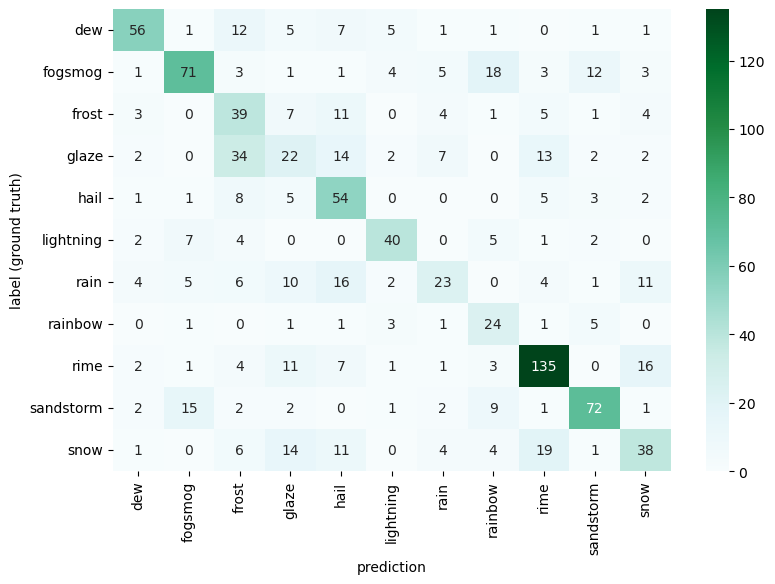

In [145]:
show_confusion_matrix(CNNmodel_best)

# AlexNet

## Loading AlexNet model

In [183]:
AlexNet = models.alexnet(pretrained=True)
AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [184]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in AlexNet.parameters():
    param.requires_grad = False

In [185]:
# Cassifier was mnodified so that we have 11 output features in the last linear layer instead of 1000 and
AlexNet.classifier[6] = nn.Linear(4096, 11)

In [187]:
# Move model to Cuda GPU
AlexNet.to(device)
next(AlexNet.parameters()).is_cuda

True

In [186]:
# These are the TRAINABLE parameters:
count_parameters(AlexNet)

Total sum of weights in the model:
	
   45056
      11
________
   45067


In [190]:
# Define loss and optimization functions
criterion_AlexNet = nn.CrossEntropyLoss()
optimizer_AlexNet = torch.optim.AdamW(AlexNet.classifier.parameters(), lr=0.001)

In [191]:
# Move optimizer state to the GPU
for state in optimizer_AlexNet.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

## Train model (AlexNet)

In [192]:
# Create lists to append losses and correct predictions per epoch
train_loss_AlexNet = []
train_corr_AlexNet = []
val_loss_AlexNet = []
val_corr_AlexNet = []

train_and_val_model(AlexNet, criterion_AlexNet, optimizer_AlexNet, train_loader, validation_loader, "AlexNet",
                        train_loss_AlexNet, train_corr_AlexNet, val_loss_AlexNet, val_corr_AlexNet)

Epoch: 1 Train loss: 1.259 Train accuracy: 78.818 %
Epoch: 1 Validation loss: 1.571 Validation accuracy: 84.114 %
best_val_acc: 84.114 counter: 0
	
Epoch: 2 Train loss: 0.149 Train accuracy: 90.539 %
Epoch: 2 Validation loss: 1.573 Validation accuracy: 87.314 %
best_val_acc: 87.314 counter: 0
	
Epoch: 3 Train loss: 0.157 Train accuracy: 95.118 %
Epoch: 3 Validation loss: 1.244 Validation accuracy: 87.771 %
best_val_acc: 87.771 counter: 0
	
Epoch: 4 Train loss: 0.037 Train accuracy: 96.954 %
Epoch: 4 Validation loss: 1.337 Validation accuracy: 88.0 %
best_val_acc: 88.0 counter: 0
	
Epoch: 5 Train loss: 0.125 Train accuracy: 98.023 %
Epoch: 5 Validation loss: 1.426 Validation accuracy: 87.543 %
best_val_acc: 88.0 counter: 1
	
Epoch: 6 Train loss: 0.034 Train accuracy: 98.769 %
Epoch: 6 Validation loss: 1.389 Validation accuracy: 88.229 %
best_val_acc: 88.229 counter: 0
	
Epoch: 7 Train loss: 0.023 Train accuracy: 99.233 %
Epoch: 7 Validation loss: 1.648 Validation accuracy: 87.429 %
best

## Evaluate model performance (AlexNet)

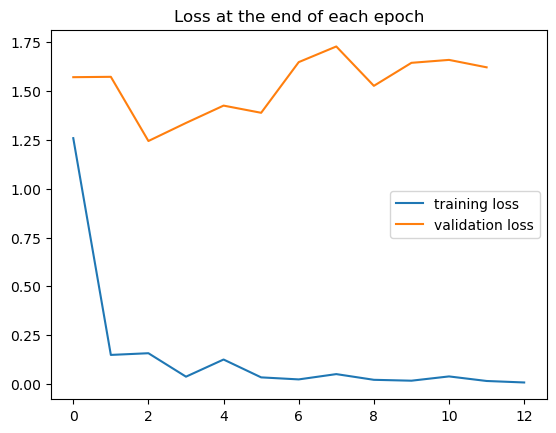

In [193]:
# Plot Losses
plt.plot([t.cpu().detach().numpy() for t in train_loss_AlexNet], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_AlexNet], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

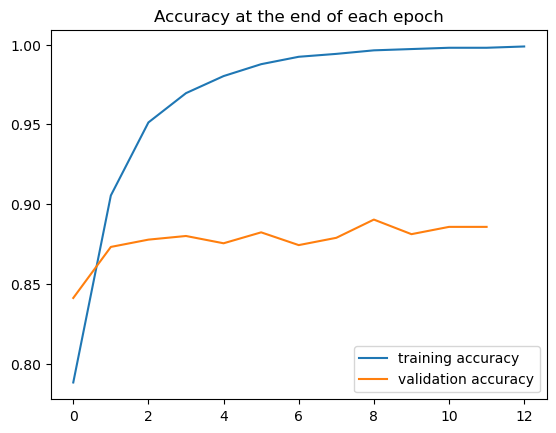

In [194]:
# Plot accuracy
plt.plot([t.cpu() / train_data_len for t in train_corr_AlexNet], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_AlexNet], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [195]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_corr_AlexNet)
print("\t")
print("Validation Correct:", val_corr_AlexNet)

Train Correct: [tensor(3907, device='cuda:0'), tensor(4488, device='cuda:0'), tensor(4715, device='cuda:0'), tensor(4806, device='cuda:0'), tensor(4859, device='cuda:0'), tensor(4896, device='cuda:0'), tensor(4919, device='cuda:0'), tensor(4928, device='cuda:0'), tensor(4939, device='cuda:0'), tensor(4943, device='cuda:0'), tensor(4947, device='cuda:0'), tensor(4947, device='cuda:0'), tensor(4951, device='cuda:0')]
	
Validation Correct: [tensor(736, device='cuda:0'), tensor(764, device='cuda:0'), tensor(768, device='cuda:0'), tensor(770, device='cuda:0'), tensor(766, device='cuda:0'), tensor(772, device='cuda:0'), tensor(765, device='cuda:0'), tensor(769, device='cuda:0'), tensor(779, device='cuda:0'), tensor(771, device='cuda:0'), tensor(775, device='cuda:0'), tensor(775, device='cuda:0')]


## Load saved model (AlexNet)

In [196]:
AlexNet_best = models.alexnet(pretrained=True)
AlexNet_best.classifier[6] = nn.Linear(4096, 11)
AlexNet_best.load_state_dict(torch.load('BestAlexNet.pt'))

<All keys matched successfully>

In [197]:
# Move model to Cuda GPU
AlexNet_best.to(device)
next(AlexNet_best.parameters()).is_cuda

True

## Test the model (AlexNet)

In [198]:
# Test the model
test_corr_AlexNet = []
test_model(AlexNet_best, criterion_AlexNet, test_loader, test_corr_AlexNet)

In [199]:
# Evaluate test data
print("Test Correct:", test_corr_AlexNet)
print("Test Accuracy:", accuracy_global, "%")

Test Correct: [tensor(903, device='cuda:0')]
Test Accuracy: 87.67 %


## Confusion Matrix (AlexNet)

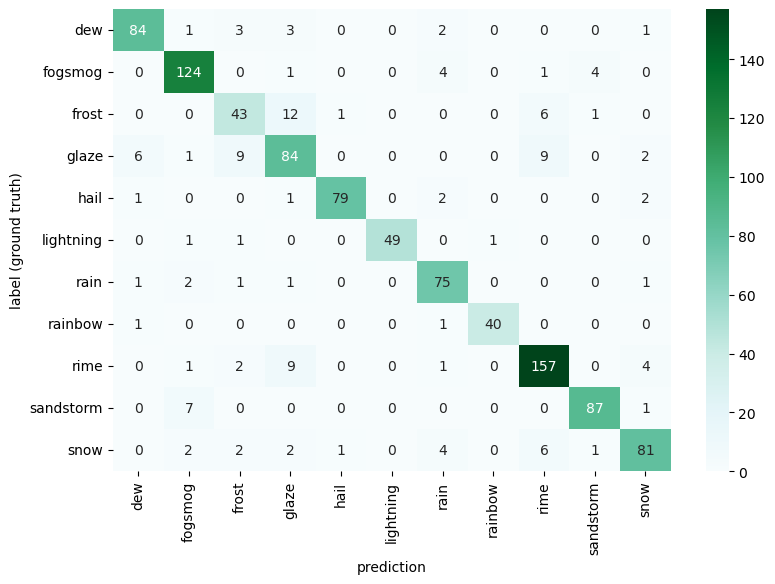

In [200]:
show_confusion_matrix(AlexNet_best)

# VGG19 with batch normalization

In [22]:
VGG19 = models.vgg19_bn(pretrained=True, progress=True)

In [24]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in VGG19.parameters():
    param.requires_grad = False

In [25]:
# Cassifier was mnodified so that we have 11 output features in the last linear layer instead of 1000 and
VGG19.classifier[6] = nn.Linear(4096, 11)
VGG19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [26]:
count_parameters(VGG19)

Total sum of weights in the model:
	
   45056
      11
________
   45067


In [30]:
# Define loss and optimization functions
criterion_VGG19 = nn.CrossEntropyLoss()
optimizer_VGG19 = torch.optim.AdamW(VGG19.classifier.parameters(), lr=0.001)

## Train model (VGG19)

In [23]:
train_losses = []
train_correct = []
validation_losses = []
validation_correct = []


Epoch: 1 Train loss: 0.615 Train accuracy: 74.44 %
Epoch: 1 Validation loss: 0.492 Validation accuracy: 84.914 %
best_val_acc: 84.914 counter: 0
	
Epoch: 2 Train loss: 0.442 Train accuracy: 86.443 %
Epoch: 2 Validation loss: 0.491 Validation accuracy: 85.714 %
best_val_acc: 85.714 counter: 0
	
Epoch: 3 Train loss: 0.134 Train accuracy: 88.541 %
Epoch: 3 Validation loss: 0.458 Validation accuracy: 85.829 %
best_val_acc: 85.829 counter: 0
	
Epoch: 4 Train loss: 0.259 Train accuracy: 91.063 %
Epoch: 4 Validation loss: 0.536 Validation accuracy: 85.714 %
best_val_acc: 85.829 counter: 1
	
Epoch: 5 Train loss: 0.12 Train accuracy: 92.455 %
Epoch: 5 Validation loss: 0.465 Validation accuracy: 86.514 %
best_val_acc: 86.514 counter: 0
	
Epoch: 6 Train loss: 0.278 Train accuracy: 94.19 %
Epoch: 6 Validation loss: 0.542 Validation accuracy: 87.886 %
best_val_acc: 87.886 counter: 0
	
Epoch: 7 Train loss: 0.263 Train accuracy: 95.219 %
Epoch: 7 Validation loss: 0.578 Validation accuracy: 86.743 %
b

## Evaluate model performance (VGG19)

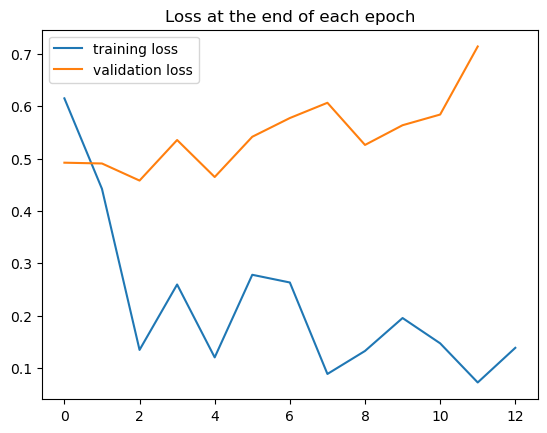

In [24]:
# Plot Losses
plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

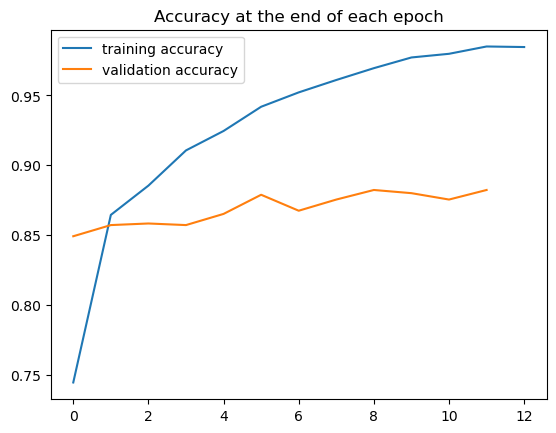

In [25]:
# Plot accuracy
plt.plot([t / train_data_len for t in train_correct], label='training accuracy')
plt.plot([t / val_data_len for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [26]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(3690), tensor(4285), tensor(4389), tensor(4514), tensor(4583), tensor(4669), tensor(4720), tensor(4764), tensor(4806), tensor(4844), tensor(4857), tensor(4883), tensor(4881)]
	
Validation Correct: [tensor(743), tensor(750), tensor(751), tensor(750), tensor(757), tensor(769), tensor(759), tensor(766), tensor(772), tensor(770), tensor(766), tensor(772)]


## Load saved model (VGG19)

In [27]:
VGG19_best = models.vgg19_bn(pretrained=True)
VGG19_best.classifier[6] = nn.Linear(4096, 11)
VGG19_best.load_state_dict(torch.load('BestVGG19.pt'))

<All keys matched successfully>

## Test the model (VGG19)

In [28]:
test_correct = []

In [29]:
# Evaluate test data
print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(908)]
Test Accuracy: 88.155 %


## Confusion matrix (VGG19) 

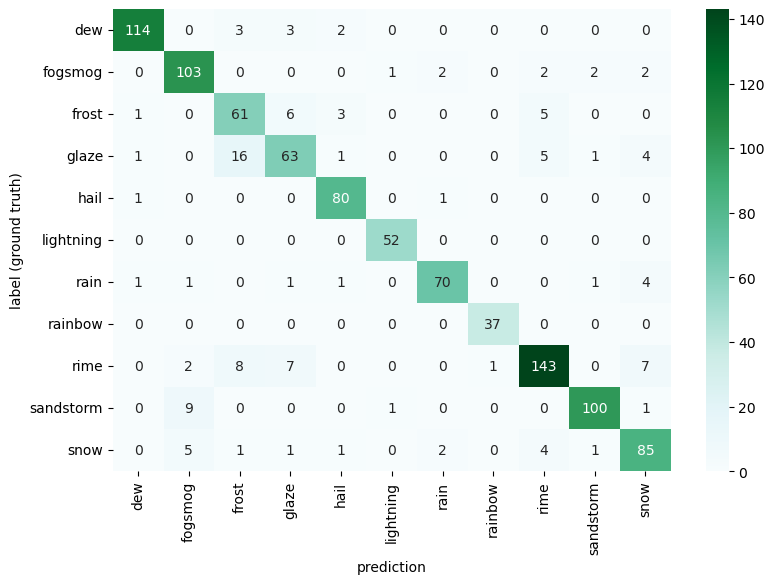

# MobileNet

In [142]:
MobileNet = models.mobilenet_v2(pretrained=True)
MobileNet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [165]:
MobileNet.to(device)
next(MobileNet.parameters()).is_cuda

True

In [152]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in MobileNet.parameters():
    param.requires_grad = False

In [153]:
# Cassifier was mnodified so that we have 11 output features in the last linear layer instead of 1000 and
MobileNet.classifier[1] = nn.Linear(1280, 11)
MobileNet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [154]:
count_parameters(MobileNet)

Total sum of weights in the model:
	
   14080
      11
________
   14091


In [166]:
# Define loss and optimization functions
criterion_MobileNet = nn.CrossEntropyLoss()
optimizer_MobileNet = torch.optim.AdamW(MobileNet.classifier.parameters(), lr=0.001)

In [167]:
# Move optimizer state to the GPU
for state in optimizer_MobileNet.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

## Train model (MobileNetv2)

In [79]:
train_losses = []
train_correct = []
validation_losses = []
validation_correct = []


Epoch: 1 Train loss: 0.728 Train accuracy: 80.855 %
Epoch: 1 Validation loss: 1.582 Validation accuracy: 85.714 %
best_val_acc: 85.714 counter: 0
	
Epoch: 2 Train loss: 0.81 Train accuracy: 86.625 %
Epoch: 2 Validation loss: 1.46 Validation accuracy: 87.429 %
best_val_acc: 87.429 counter: 0
	
Epoch: 3 Train loss: 0.281 Train accuracy: 88.743 %
Epoch: 3 Validation loss: 1.521 Validation accuracy: 88.914 %
best_val_acc: 88.914 counter: 0
	
Epoch: 4 Train loss: 0.666 Train accuracy: 90.095 %
Epoch: 4 Validation loss: 1.745 Validation accuracy: 89.486 %
best_val_acc: 89.486 counter: 0
	
Epoch: 5 Train loss: 0.2 Train accuracy: 91.103 %
Epoch: 5 Validation loss: 1.629 Validation accuracy: 88.343 %
best_val_acc: 89.486 counter: 1
	
Epoch: 6 Train loss: 0.146 Train accuracy: 91.85 %
Epoch: 6 Validation loss: 1.793 Validation accuracy: 90.057 %
best_val_acc: 90.057 counter: 0
	
Epoch: 7 Train loss: 0.28 Train accuracy: 92.516 %
Epoch: 7 Validation loss: 1.465 Validation accuracy: 89.257 %
best

## Evaluate model performance (MobileNet)

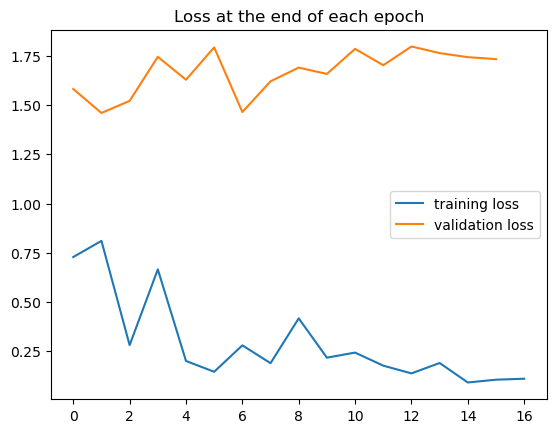

In [80]:
# Plot Losses
plt.plot([t.cpu().detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in validation_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

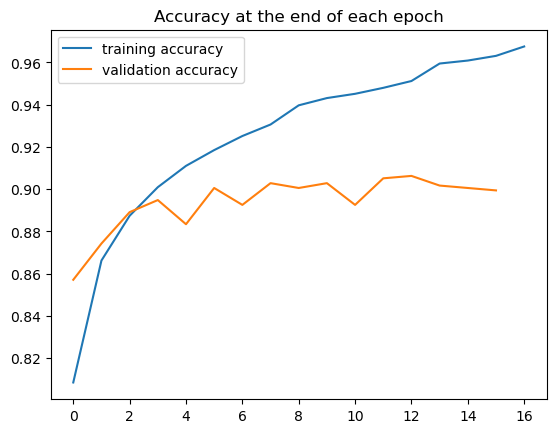

In [81]:
# Plot accuracy
plt.plot([t.cpu() / train_data_len for t in train_correct], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in validation_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [82]:
# How many accurate predictions were made per epoch
print("Train Correct:", train_correct)
print("\t")
print("Validation Correct:", validation_correct)

Train Correct: [tensor(4008, device='cuda:0'), tensor(4294, device='cuda:0'), tensor(4399, device='cuda:0'), tensor(4466, device='cuda:0'), tensor(4516, device='cuda:0'), tensor(4553, device='cuda:0'), tensor(4586, device='cuda:0'), tensor(4613, device='cuda:0'), tensor(4658, device='cuda:0'), tensor(4675, device='cuda:0'), tensor(4685, device='cuda:0'), tensor(4699, device='cuda:0'), tensor(4715, device='cuda:0'), tensor(4756, device='cuda:0'), tensor(4763, device='cuda:0'), tensor(4774, device='cuda:0'), tensor(4796, device='cuda:0')]
	
Validation Correct: [tensor(750, device='cuda:0'), tensor(765, device='cuda:0'), tensor(778, device='cuda:0'), tensor(783, device='cuda:0'), tensor(773, device='cuda:0'), tensor(788, device='cuda:0'), tensor(781, device='cuda:0'), tensor(790, device='cuda:0'), tensor(788, device='cuda:0'), tensor(790, device='cuda:0'), tensor(781, device='cuda:0'), tensor(792, device='cuda:0'), tensor(793, device='cuda:0'), tensor(789, device='cuda:0'), tensor(788, de

## Load saved model (MobileNet)

In [83]:
MobileNet_best = models.mobilenet_v2(pretrained=True)
MobileNet_best.classifier[1] = nn.Linear(1280, 11)
MobileNet_best.load_state_dict(torch.load('BestMobileNet.pt'))

<All keys matched successfully>

In [84]:
MobileNet_best.to(device)
next(MobileNet_best.parameters()).is_cuda

True

## Test the model (MobileNet)

In [85]:
test_correct = []


In [86]:
# Evaluate test data
print("Test Correct:", test_correct)
print("Test Accuracy:", accuracy, "%")

Test Correct: [tensor(905, device='cuda:0')]
Test Accuracy: 87.864 %


## Confusion matrix (MobileNet)

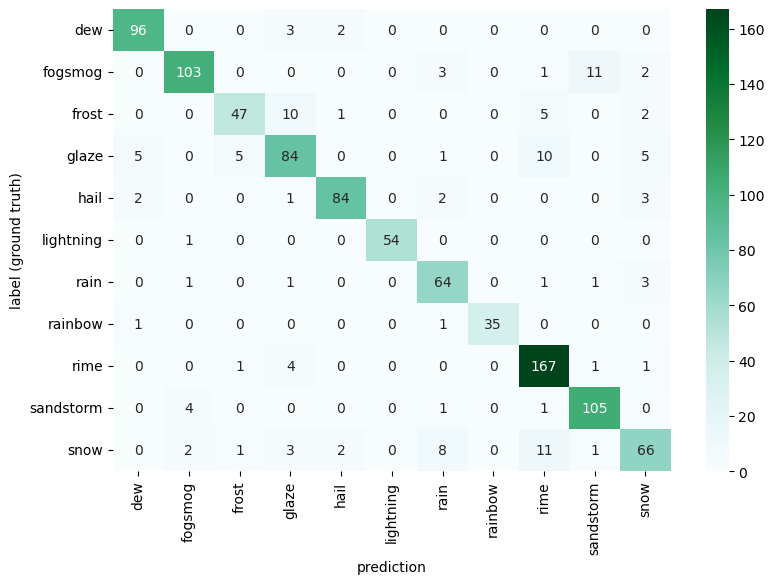

# ShuffleNet

In [229]:
ShuffleNet = models.shufflenet_v2_x2_0(pretrained=True)
ShuffleNet

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [248]:
ShuffleNet.to(device)
next(ShuffleNet.parameters()).is_cuda

True

In [239]:
# Freeze the pre-trained layers to prevent their weights from being updated
for param in ShuffleNet.parameters():
    param.requires_grad = False

In [240]:
# Cassifier was modified so that we have 11 output features in the last linear layer instead of 1000 and
ShuffleNet.fc = nn.Linear(2048, 11)
ShuffleNet

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

In [241]:
count_parameters(ShuffleNet)

Total sum of weights in the model:
	
   22528
      11
________
   22539


In [242]:
# Define loss and optimization functions
criterion_ShuffleNet = nn.CrossEntropyLoss()
optimizer_ShuffleNet = torch.optim.AdamW(ShuffleNet.fc.parameters(), lr=0.001)

In [249]:
# Move optimizer state to the GPU
for state in optimizer_ShuffleNet.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [250]:
train_loss_ShuffleNet = []
train_corr_ShuffleNet = []
val_loss_ShuffleNet = []
val_corr_ShuffleNet = []

train_and_val_model(ShuffleNet, criterion_ShuffleNet, optimizer_ShuffleNet, train_loader, validation_loader, "ShuffleNet",
                   train_loss_ShuffleNet, train_corr_ShuffleNet, val_loss_ShuffleNet, val_corr_ShuffleNet)

Epoch: 1 Train loss: 0.608 Train accuracy: 75.388 %
Epoch: 1 Validation loss: 0.532 Validation accuracy: 86.057 %
best_val_acc: 86.057 counter: 0
	
Epoch: 2 Train loss: 1.549 Train accuracy: 87.19 %
Epoch: 2 Validation loss: 0.339 Validation accuracy: 86.4 %
best_val_acc: 86.4 counter: 0
	
Epoch: 3 Train loss: 0.168 Train accuracy: 90.357 %
Epoch: 3 Validation loss: 0.431 Validation accuracy: 87.771 %
best_val_acc: 87.771 counter: 0
	
Epoch: 4 Train loss: 0.304 Train accuracy: 92.374 %
Epoch: 4 Validation loss: 0.372 Validation accuracy: 88.343 %
best_val_acc: 88.343 counter: 0
	
Epoch: 5 Train loss: 0.149 Train accuracy: 93.323 %
Epoch: 5 Validation loss: 0.358 Validation accuracy: 88.8 %
best_val_acc: 88.8 counter: 0
	
Epoch: 6 Train loss: 0.161 Train accuracy: 94.573 %
Epoch: 6 Validation loss: 0.388 Validation accuracy: 88.8 %
best_val_acc: 88.8 counter: 1
	
Epoch: 7 Train loss: 0.115 Train accuracy: 95.138 %
Epoch: 7 Validation loss: 0.412 Validation accuracy: 87.886 %
best_val_ac

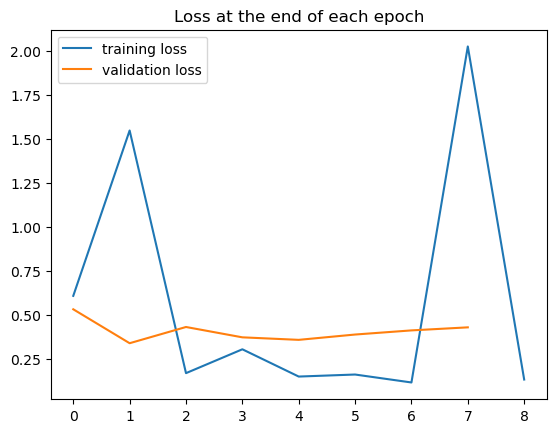

In [251]:
# Plot Losses
plt.plot([t.cpu().detach().numpy() for t in train_loss_ShuffleNet], label='training loss')
plt.plot([t.cpu().detach().numpy() for t in val_loss_ShuffleNet], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

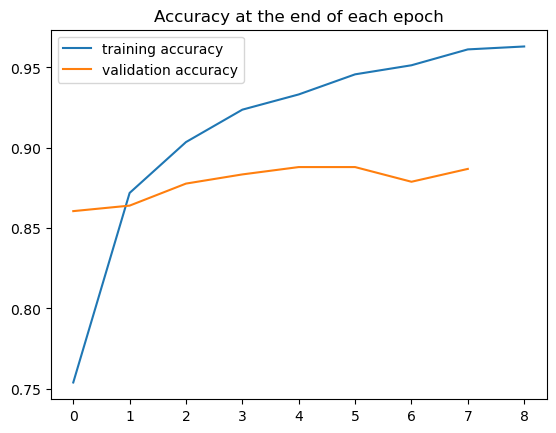

In [252]:
# Plot accuracy
plt.plot([t.cpu() / train_data_len for t in train_corr_ShuffleNet], label='training accuracy')
plt.plot([t.cpu() / val_data_len for t in val_corr_ShuffleNet], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Open a custom image and use the models for prediction

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	


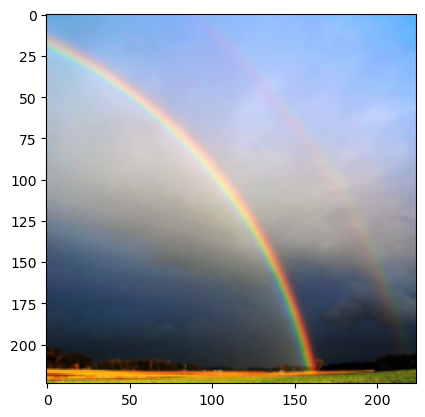

In [181]:
# Open a custom image
custom_img = Image.open('custom_images/1.jpg')

# Define transformations for the image
transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

# Inverse normalize the image
custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

print("Classes:", classes)
print("\t")

In [182]:
# CNN Model Prediction:
custom_img_prediction(CNNmodel_best, "Custom CNN")

Custom CNN model prediction: 9


In [198]:
# AlexNet Model Prediction:
custom_img_prediction(ALexNet_best, :"AlexNet")

AlexNet model prediction: 7


In [32]:
# VGG19 Model Prediction:
custom_img_prediction(VGG19_best, "VGG19")

VGG19 model prediction: 7


In [98]:
# MobileNet Model Prediction:
custom_img_prediction(MobileNet_best, "MobileNet")

MobileNet model prediction: 7
